# Support Vector Machine

The purpose of this notebook is to predict whether an applicant is approved for a loan using a Support Vector Machine. The original dataset and definition of the problem corresponds to the following [Kaggle](https://www.kaggle.com/competitions/playground-series-s4e10/overview) competition, which we need to submit and participate as well.

In [2]:
import pandas as pd

pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 50)

import numpy as np

np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.rc('font', size=12)
plt.rc('figure', figsize=(12, 5))

import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2, 'font.family': [u'times']})

from sklearn import svm

In [3]:
train_set = pd.read_csv('./dataset/train.csv', index_col=0)
test_set = pd.read_csv('./dataset/test.csv')

# Data Exploration

The first step to any machine learning project is explore the data, so that we can know what we are working with. That process will help us in the future to decide how we can process and use this data.

In [4]:
print(train_set.shape[0])
print(test_set.shape[0])

58645
39098


In [5]:
train_set.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
id,,,,,,,,,,,,
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [6]:
train_set.dtypes

person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
loan_status                     int64
dtype: object

In [7]:
train_set.select_dtypes(include=['object']).head()

,person_home_ownership,loan_intent,loan_grade,cb_person_default_on_file
id,,,,
0,RENT,EDUCATION,B,N
1,OWN,MEDICAL,C,N
2,OWN,PERSONAL,A,N
3,RENT,VENTURE,B,N
4,RENT,MEDICAL,A,N


The previous cells allow us to see some of the properties from the dataset, such as the relation between the test and train size, the amount of columns and the type of datatypes in the dataset. This dataset contains 4 columns that use categorical datatypes, we will probably need to One-hot encode them in the future.

In the following steps we will proceed to check the dataquality of the whole dataset. We will begin by looking for NaNs.

In [8]:
train_set.isna().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64

As we can see, the training dataset does not contain any NaN. This is great news because we will be able to use all the data without the need to fill the gaps with expected values or dropping the huge voids.

Now we will check for data that we know for sure is not correct in the columns (age, income, employment length, loan amount)

In [9]:
# Ages need to be natural
print(f'Minimum age: {train_set['person_age'].min()}, Maximum age: {train_set['person_age'].max()}')

# Income will always be positive
print(f'Minimum income: {train_set['person_income'].min()} ')

# Employment length can not be longer than person age
print(f"Any employment length longer than age: {any(train_set['person_age'] <= train_set['person_emp_length'])}")

# Loan amount will always be positive
print(f'Minimum loan: {train_set['loan_amnt'].min()} ')


Minimum age: 20, Maximum age: 123
Minimum income: 4200 
Any employment length longer than age: True
Minimum loan: 500 


From the previous results we can see that some data from the dataset is incorrect such as a person being 123 years old and someone who worked for more years than they have been alive.

# Data Preprocessing
The next step after exploring the data is the preprocessing part, where we will clean, normalise, and remove all the irrelevant data.

### Data Cleaning
As we saw in the previous chapter, some data does not make any sense, we will begin by removing all this cases.

In [10]:
def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    # Filter for age between 20 and 100
    df = df[(df['person_age'] >= 20) & (df['person_age'] <= 100)]
    
    # Filter for positive income
    df = df[df['person_income'] > 0]
    
    # Filter where the difference between age and employment length is at least 16
    df = df[(df['person_age'] - df['person_emp_length']) >= 16]
    
    # Filter for positive loan amount
    df = df[df['loan_amnt'] > 0]
    
    return df

train_set = clean_data(train_set)

### Data Encoding
Now we will proceed to One-Hot encode all the categorical columns.

In [11]:
def OH_encode(df: pd.DataFrame, feature: str):
    dummies = pd.get_dummies(df[[feature]], dtype=int)
    df = df.drop(feature, axis=1)
    res = pd.concat([df, dummies], axis=1)
    return res

train_set_OH = train_set.copy()

for f in list(train_set.select_dtypes(include='object').columns):
        train_set_OH = OH_encode(train_set_OH, f)


In [12]:
train_set_OH

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_N,cb_person_default_on_file_Y
id,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,37,35000,0.0,6000,11.49,0.17,14,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0
1,22,56000,6.0,4000,13.35,0.07,2,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
2,29,28800,8.0,6000,8.90,0.21,10,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0
3,30,70000,14.0,12000,11.11,0.17,5,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0
4,22,60000,2.0,6000,6.92,0.10,3,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58640,34,120000,5.0,25000,15.95,0.21,10,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
58641,28,28800,0.0,10000,12.73,0.35,8,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
58642,23,44000,7.0,6800,16.00,0.15,2,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0


### Data Normalisation
In the next step we will normalise the data.

In [13]:
def normalize_column(col: pd.Series):
    return col / col.abs().max()

def normalize_df(df: pd.DataFrame):
    for col in df.columns:
        df[col] = normalize_column(df[col])
    
    return df

train_set_OH = normalize_df(train_set_OH)

In [14]:
train_set_OH

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_N,cb_person_default_on_file_Y
id,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.440476,0.018421,0.000000,0.171429,0.494832,0.204819,0.466667,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.261905,0.029474,0.146341,0.114286,0.574935,0.084337,0.066667,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.345238,0.015158,0.195122,0.171429,0.383290,0.253012,0.333333,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.357143,0.036842,0.341463,0.342857,0.478467,0.204819,0.166667,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.261905,0.031579,0.048780,0.171429,0.298019,0.120482,0.100000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58640,0.404762,0.063158,0.121951,0.714286,0.686908,0.253012,0.333333,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
58641,0.333333,0.015158,0.000000,0.285714,0.548234,0.421687,0.266667,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
58642,0.273810,0.023158,0.170732,0.194286,0.689061,0.180723,0.066667,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


### Data Transformation
Now that we have normalized the data we can check for the higher correlation between all the features.

In [15]:
# Get correlations and flatten them
corr_matrix = train_set_OH[train_set_OH.columns].corr()

n = corr_matrix.shape[0]
mask = np.tri(n, n, 0, dtype=bool)
corr_matrix[mask] = np.nan

corr_matrix = corr_matrix.stack().reset_index()
corr_matrix.columns = ['F1', 'F2', 'Corr']

top_5_corr = corr_matrix.nlargest(5, 'Corr')
bot_5_corr = corr_matrix.nsmallest(5, 'Corr')

print(top_5_corr)
print(bot_5_corr)

                F1                           F2      Corr
5       person_age   cb_person_cred_hist_length  0.876292
76       loan_amnt          loan_percent_income  0.646876
119  loan_int_rate  cb_person_default_on_file_Y  0.501420
114  loan_int_rate                 loan_grade_D  0.476913
335   loan_grade_C  cb_person_default_on_file_Y  0.475093
                                 F1                           F2      Corr
350     cb_person_default_on_file_N  cb_person_default_on_file_Y -1.000000
182  person_home_ownership_MORTGAGE   person_home_ownership_RENT -0.895226
111                   loan_int_rate                 loan_grade_A -0.822288
315                    loan_grade_A                 loan_grade_B -0.544994
118                   loan_int_rate  cb_person_default_on_file_N -0.501420


From the previous correlation results, we can see that there is a high correlation between a person's age and their credit history, which makes sense since the older you are the highest credit you have used. On the other side, leaving out the negative correlation on the result which is obvious, since its True or False, we can also see a huge negative correlation between the mortgage column and the rent column, as well as between the loan interest rate and the grade A loan.

Regarding the relationship between the person age and the credit history length, we will combine this two features in order to create a new one which will better represent the data. This relationship will be $\text{credit hist rat} = \frac{\text{person age}}{\text{cb person cred hist length}}$.

For the first negative correlation, we will not make any changes before we study the significance of it. They represent the same features that has been One-Hot encoded, meaning that it could be possible that there are only three types of homeowner-ship and the majority of them are either mortgage or rent at similar proportions.

However, on the second negative correlation we are comparing the loan interest rate against the loan grade of type A. We will apply a multiplicative interaction between them.

In [16]:
def data_transform(df: pd.DataFrame):
    df['credit_hist_rat'] = df['person_age'] / df['cb_person_cred_hist_length']
    df['loan_int_A'] = df['loan_int_rate'] * df['loan_grade_A']
    
    return df

train_set_OH = data_transform(train_set_OH)
train_set_OH['credit_hist_rat'] = normalize_column(train_set_OH['credit_hist_rat'])
train_set_OH['loan_int_A'] = normalize_column(train_set_OH['loan_int_A'])

<function matplotlib.pyplot.plot(*args: 'float | ArrayLike | str', scalex: 'bool' = True, scaley: 'bool' = True, data=None, **kwargs) -> 'list[Line2D]'>

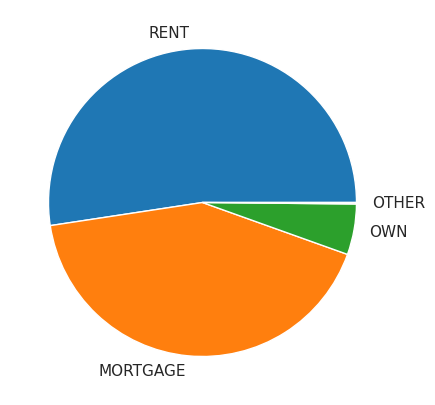

In [17]:
s = train_set['person_home_ownership'].value_counts()
plt.pie(s, labels=s.index)
plt.plot

As we expected, there is a huge negative correlation because it is the same feature that statistically will either be 'RENT' or 'MORTGAGE'.

## SVM model application

Once all the data has been properly preprocessed, we will proceed to apply an SVM model with the objective to predict the loan status, therefore, we will apply an SVM classifier (SVC).

Since SVCs can use several types of kernels, we will try to use different ones and evaluate them in separate. To evaluate the results, Kaggle applies an [area under de ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve) method. We can import this function from sklearn.

In [18]:
import multiprocessing as mp
from sklearn.metrics import roc_auc_score

In [19]:
y_train = train_set_OH['loan_status']
x_train = train_set_OH.drop(columns=['loan_status'])

In [20]:
def model_fit_pred(model: svm.SVC, x: pd.DataFrame, y: pd.DataFrame):
    model.fit(x, y)
    return model.predict(x)

def get_score(model: svm.SVC, x: pd.DataFrame, y: pd.DataFrame):
    return roc_auc_score(y, model_fit_pred(model, x, y))

# For the poly and rbf models we could tweak some features, for the first run we will keep it default.
models_A = {
    'linearModel': svm.SVC(kernel='linear'),
    'polyModel': svm.SVC(kernel='poly'),
    'rbfModel': svm.SVC(kernel='rbf')
}

# We will parallelize to get results faster
pool = mp.Pool(mp.cpu_count())
scores = {modelT: pool.apply(get_score, args=(model, x_train, y_train)) for modelT, model in models_A.items()}
pool.close()


print(dict(sorted(scores.items(), reverse=True, key=lambda item: item[1])))

{'polyModel': np.float64(0.8102877344978626), 'rbfModel': np.float64(0.8015722383864098), 'linearModel': np.float64(0.744796262917178)}


We can see how the polyModel and the rbfModel are able to reach on to the 80% mark, while the linear model. Since both the polyModel and the rbfModel accept tweaking, and they have the best results, we will continue the exploration with these models with the objective to reach even higher scores.

For the polyModel we will try to augment the degree so that we can get a more precise separation, this could increase the overfitting of the model, therefore we need to be cautions and interpret the results with a pinch of salt. On the other hand, for the rbfModel we will try to change the gamma from the default ('scale'= 1 / (n_features * X.var())) to 'auto' = 1 /n_features.

In [21]:
models_B = {
    'polyModel': svm.SVC(kernel='poly', degree=6),
    'rbfModel': svm.SVC(kernel='rbf', gamma='auto')
}

# We will parallelize to get results faster
pool = mp.Pool(mp.cpu_count())
scores = {modelT: pool.apply(get_score, args=(model, x_train, y_train)) for modelT, model in models_B.items()}
pool.close()


print(dict(sorted(scores.items(), reverse=False, key=lambda item: item[1])))

{'rbfModel': np.float64(0.7151131794586567), 'polyModel': np.float64(0.8253502956050777)}


After this second run, we can see how the polyModel slightly improved from 0.81 to 0.83, on the other side the rbfModel score decreased by 0.09, which is not ideal. Given that the scores easily fluctuate depending on the values used for tweaking the model, we need to have a higher accuracy when choosing those configurations.
To solve this, we will use a tool called GridSearchCV from the sklearn library. This tool will allow us to exhaustively search for the best values in the fit process.


In [22]:
from sklearn.model_selection import GridSearchCV

In [23]:
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
}

# Initialize the SVM model
svm = svm.SVC(kernel='rbf')

# Set up Grid Search with cross-validation
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001]},
             scoring='accuracy', verbose=1)

In [24]:
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'C': 1000, 'gamma': 0.1}
Best Score: 0.9421283205510893


In [25]:
# <# Test preparation
# test_ids = test_set['id']
# x_test = test_set.drop(columns='id')
# 
# for f in list(x_test.select_dtypes(include='object').columns):
#         x_test = OH_encode(x_test, f)
# 
# x_test = data_transform(x_test)
# x_test = normalize_df(x_test)
# 
# model = models_B.get('polyModel')
# 
# model.fit(x_train, y_train)
# 
# # Test
# y_pred_test = model.predict(x_test)
# 
# df_output = pd.DataFrame({'id': test_ids, 'loan_status': y_pred_test})
# 
# 
# df_output.to_csv('pred_loan.csv',index=False)